<a href="https://colab.research.google.com/github/HarshitChaudhary111/GenAi/blob/main/Lab%201/GenAI_Medical_XRAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!cat kaggle.json

{"username":"harshitbhaichaudhary","key":"f61c8f781efffadfe352b94881f79d1e"}

In [4]:

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

Dataset URL: https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis
License(s): other
 99% 1.73G/1.74G [00:24<00:00, 44.9MB/s]
100% 1.74G/1.74G [00:24<00:00, 76.8MB/s]


In [6]:
!unzip chest-xray-pneumoniacovid19tuberculosis.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/NORMAL/NORMAL2-IM-0843-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0845-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0846-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0847-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0848-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0849-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0851-0001-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0851-0001-0002.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0851-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0852-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0853-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0854-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0855-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0856-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0857-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0858-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0859-0001.jpeg  
  inflating: train/NO

In [7]:
!ls

chest-xray-pneumoniacovid19tuberculosis.zip  sample_data  train
kaggle.json				     test	  val


In [8]:
!mv train/TURBERCULOSIS train/TUBERCULOSIS
!mv val/TURBERCULOSIS val/TUBERCULOSIS
!mv test/TURBERCULOSIS test/TUBERCULOSIS


In [9]:
!ls train
!ls val
!ls test

COVID19  NORMAL  PNEUMONIA  TUBERCULOSIS
COVID19  NORMAL  PNEUMONIA  TUBERCULOSIS
COVID19  NORMAL  PNEUMONIA  TUBERCULOSIS


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

eval_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder("/content/train", transform=train_tfms)
val_ds   = datasets.ImageFolder("/content/val",   transform=eval_tfms)
test_ds  = datasets.ImageFolder("/content/test",  transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=16, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=16, num_workers=0)

print("Classes:", train_ds.class_to_idx)


Classes: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TUBERCULOSIS': 3}


In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [12]:
!ls /content

chest-xray-pneumoniacovid19tuberculosis.zip  sample_data  train
kaggle.json				     test	  val


In [13]:
def train_epoch():
    model.train()
    total = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total/len(train_loader)

def eval_epoch(loader):
    model.eval()
    correct=total=0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            _,p = model(x).max(1)
            total += y.size(0)
            correct += (p==y).sum().item()
    return correct/total

In [14]:
model = timm.create_model(
    "densenet121",
    pretrained=True,
    num_classes=4
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Model defined and moved to device")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Model defined and moved to device


In [15]:
print(type(model))

<class 'timm.models.densenet.DenseNet'>


In [16]:
best = 0.0

for epoch in range(1, 11):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    val_acc = eval_epoch(val_loader)
    print(f"Epoch {epoch} | Loss {running_loss/len(train_loader):.4f} | Val Acc {val_acc:.4f}")

    if val_acc > best:
        best = val_acc
        torch.save(model.state_dict(), "best_densenet.pth")

Epoch 1 | Loss 0.2842 | Val Acc 0.7895
Epoch 2 | Loss 0.0946 | Val Acc 0.9211
Epoch 3 | Loss 0.0722 | Val Acc 0.8158
Epoch 4 | Loss 0.0503 | Val Acc 0.9474
Epoch 5 | Loss 0.0474 | Val Acc 0.9474
Epoch 6 | Loss 0.0425 | Val Acc 0.9474
Epoch 7 | Loss 0.0286 | Val Acc 0.9474
Epoch 8 | Loss 0.0255 | Val Acc 0.8947
Epoch 9 | Loss 0.0279 | Val Acc 0.8421
Epoch 10 | Loss 0.0228 | Val Acc 0.9474


In [17]:
model.load_state_dict(torch.load("best_densenet.pth"))
test_acc = eval_epoch(test_loader)
print("Final Test Accuracy:", test_acc)

Final Test Accuracy: 0.8767833981841764


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(model)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


In [20]:

def train_epoch():
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def eval_epoch(loader):
    model.eval()
    correct = total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total


In [21]:
best_acc = 0.0

for epoch in range(1, 16):
    loss = train_epoch()
    val_acc = eval_epoch(val_loader)

    print(f"Epoch {epoch} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_cnn.pth")

Epoch 1 | Loss: 0.4844 | Val Acc: 0.6053
Epoch 2 | Loss: 0.2563 | Val Acc: 0.7105
Epoch 3 | Loss: 0.2264 | Val Acc: 0.7368
Epoch 4 | Loss: 0.2028 | Val Acc: 0.8421
Epoch 5 | Loss: 0.1854 | Val Acc: 0.8421
Epoch 6 | Loss: 0.1881 | Val Acc: 0.8158
Epoch 7 | Loss: 0.1634 | Val Acc: 0.6842
Epoch 8 | Loss: 0.1621 | Val Acc: 0.6842
Epoch 9 | Loss: 0.1603 | Val Acc: 0.7895
Epoch 10 | Loss: 0.1486 | Val Acc: 0.7632
Epoch 11 | Loss: 0.1423 | Val Acc: 0.7895
Epoch 12 | Loss: 0.1374 | Val Acc: 0.7895
Epoch 13 | Loss: 0.1347 | Val Acc: 0.8684
Epoch 14 | Loss: 0.1308 | Val Acc: 0.8421
Epoch 15 | Loss: 0.1276 | Val Acc: 0.7368


In [22]:

model.load_state_dict(torch.load("best_cnn.pth"))
test_acc = eval_epoch(test_loader)
print("Custom CNN Test Accuracy:", test_acc)


Custom CNN Test Accuracy: 0.8054474708171206


In [23]:
import torch

def evaluate_model(model, loader):
    model.eval()
    correct = total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total

In [25]:
densenet = timm.create_model(
    "densenet121",
    pretrained=False,
    num_classes=4
).to(device)

densenet.load_state_dict(torch.load("best_densenet.pth"))

# Load Custom CNN
custom_cnn = CustomCNN(num_classes=4).to(device)
custom_cnn.load_state_dict(torch.load("best_cnn.pth"))

# Evaluate
densenet_acc = evaluate_model(densenet, test_loader)
cnn_acc = evaluate_model(custom_cnn, test_loader)

print(f"DenseNet Test Accuracy: {densenet_acc:.4f}")
print(f"CNN Test Accuracy: {cnn_acc:.4f}")


DenseNet Test Accuracy: 0.8768
CNN Test Accuracy: 0.8054


In [30]:
torch.save(best_model.state_dict(), "final_best_model.pth")

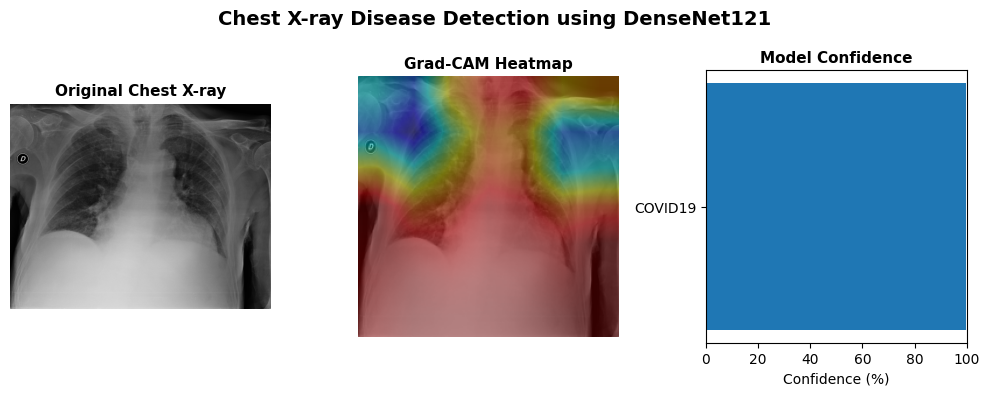

Predicted Disease : COVID19
Model Confidence  : 99.82%


In [33]:
import torch
import timm
import gradio as gr
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms

CLASSES = ["COVID19", "NORMAL", "PNEUMONIA", "TUBERCULOSIS"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("densenet121", pretrained=False, num_classes=4)
model.load_state_dict(torch.load("final_best_model.pth", map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self):
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam[0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

gradcam = GradCAM(model, model.features[-1])

def predict_xray(image):
    try:
        image = image.convert("RGB")
        orig = np.array(image.resize((224,224)))

        img = transform(image).unsqueeze(0).to(device)
        output = model(img)
        probs = torch.softmax(output, dim=1)

        pred = torch.argmax(probs, dim=1).item()

        model.zero_grad()
        output[0, pred].backward()

        cam = gradcam.generate()
        cam = cv2.resize(cam, (224,224))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)

        return (
            CLASSES[pred],
            f"{probs[0][pred].item()*100:.2f}%",
            Image.fromarray(overlay)
        )

    except Exception as e:
        return "Error", "Error", None

# ---------------- GUI ----------------
import matplotlib.pyplot as plt

sample_image_path = "/content/test/COVID19/COVID19(461).jpg"  # keep one test image in repo
image = Image.open(sample_image_path)

label, confidence, heatmap = predict_xray(image)

confidence_val = float(confidence.replace("%", ""))

plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Chest X-ray", fontsize=11, fontweight="bold")

# Grad-CAM heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.axis("off")
plt.title("Grad-CAM Heatmap", fontsize=11, fontweight="bold")

# Confidence bar
plt.subplot(1, 3, 3)
plt.barh([label], [confidence_val])
plt.xlim(0, 100)
plt.xlabel("Confidence (%)")
plt.title("Model Confidence", fontsize=11, fontweight="bold")

plt.suptitle(
    "Chest X-ray Disease Detection using DenseNet121",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()

print("Predicted Disease :", label)
print("Model Confidence  :", confidence)

